In [7]:
import numpy as np
import pandas as pd
from dowhy import CausalModel
import graphviz
import warnings
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV
from sklearn.ensemble import GradientBoostingRegressor
# EconML imports
from econml.dml import LinearDML, CausalForestDML
from econml.cate_interpreter import SingleTreeCateInterpreter, SingleTreePolicyInterpreter
import seaborn as sns
import dowhy.plotter
%matplotlib inline
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')



# The Direct Acyclic Graph

G=graphviz.Digraph()
G.edge("ta_h" , "tr")
G.edge("vel_h" , "ta_h")
G.edge("rh" , "ta_h")
G.edge("ta_h" , "clo")
G.edge("ta_h" , "thermal_sensation")
G.edge("vel_h" , "tr")
G.edge("rh" , "tr")
G.edge("tr" , "clo")
G.edge("tr" , "thermal_sensation")
G.edge("vel_h" , "clo")
G.edge("vel_h" , "thermal_sensation")
G.edge("rh" , "clo")
G.edge("rh" , "thermal_sensation")
G.edge("met" , "thermal_sensation")
G.edge("clo" , "thermal_sensation")

######################################
#########################################

G.edge("bmi_coded" , "met")
G.edge("bmi_coded" , "clo")
G.edge("bmi_coded" , "thermal_sensation")


# print(dot.source)

G.format = 'pdf'
G.render(directory='DAG', view = False).replace('\\', '/')



'DAG/Digraph.gv.pdf'

In [10]:
# Reading the data
data = pd.read_excel("data.xlsx")

data_for_causal = data[["ta_h","tr", "vel_h", "rh", "met", "clo", "thermal_sensation", "ht", "wt", "age"]]


bin_width = 10
data_for_causal['age_bins'] = pd.cut(data_for_causal['age'], bins=pd.interval_range(start=data_for_causal['age'].min(), end=data_for_causal['age'].max()+bin_width, freq=bin_width), include_lowest=True)


# data_for_causal = data_for_causal.loc[(data_for_causal['age'] >=26) & (data_for_causal['age'] <=36)]
# data_for_causal= data_for_causal.drop(labels='age', axis=1)
data_for_causal = data_for_causal.dropna()

In [11]:
data_for_causal.shape

In [12]:
data_for_causal['bmi'] = data_for_causal['wt']/((data_for_causal['ht']) ** 2)

In [13]:
conditions = [(data_for_causal['bmi'] < 18.5),
                (data_for_causal['bmi'] >= 18.5) & (data_for_causal['bmi'] < 24.9),
                (data_for_causal['bmi'] >= 24.9) & (data_for_causal['bmi'] <= 29.9),
                (data_for_causal['bmi']>29.9)]

choices = ["Underweight","Normal weight", "Overweight","Obesity"]

data_for_causal['bmi_coded'] = np.select(conditions, choices, default=-2)

In [16]:
data_for_causal.groupby(['age_bins', 'bmi_coded'])['bmi_coded'].count()

age_bins      bmi_coded    
(6.0, 16.0]   Normal weight     0
              Obesity           0
              Overweight        0
              Underweight       0
(16.0, 26.0]  Normal weight     7
              Obesity           1
              Overweight        1
              Underweight       0
(26.0, 36.0]  Normal weight     9
              Obesity           5
              Overweight        7
              Underweight       0
(36.0, 46.0]  Normal weight     1
              Obesity           0
              Overweight        0
              Underweight       0
(46.0, 56.0]  Normal weight    20
              Obesity          14
              Overweight       18
              Underweight       1
(56.0, 66.0]  Normal weight     0
              Obesity           0
              Overweight        0
              Underweight       0
(66.0, 76.0]  Normal weight     7
              Obesity          11
              Overweight       14
              Underweight       4
(76.0, 86.0]  Normal

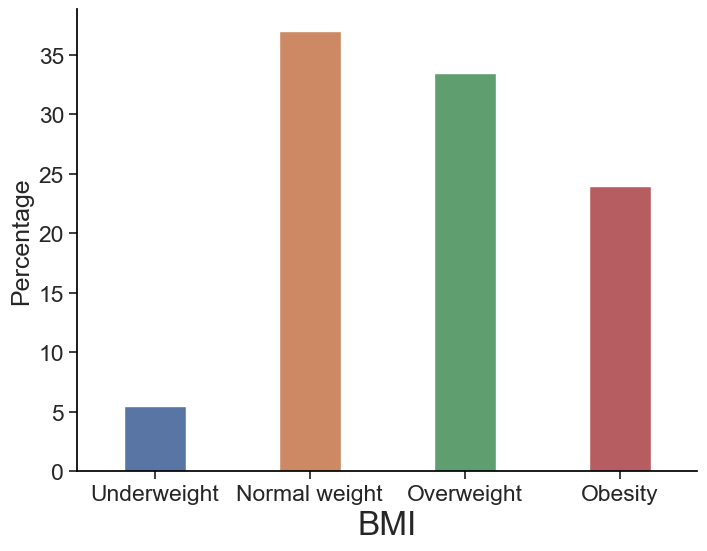

In [6]:
df_percentages = data_for_causal['bmi_coded'].value_counts(normalize=True).reset_index(name='Percentage')
df_percentages['Percentage'] *= 100


plt.figure(figsize=(8,6))
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params, font_scale=1.5)
plt.rcParams["axes.edgecolor"] = "black"
draw = sns.barplot(x = df_percentages['index'], y = df_percentages['Percentage'], width=0.4, order=["Underweight","Normal weight", "Overweight","Obesity"])
draw.set_xlabel("BMI",fontsize=24)
# draw.set_ylabel("Thermal sensation",fontsize=24)
# draw.set(ylim=(0, 250))
figure = draw.get_figure()
figure.savefig('bmi.png', bbox_inches='tight', dpi=300)

In [5]:
bmi = data_for_causal.copy()
bmi = bmi.drop(labels=['wt','ht', "bmi"], axis=1)


bmi["bmi_coded"] = bmi['bmi_coded'].replace(["underweight", "normal weight", "overweight", "obesity"], 
                                                                           [1,2,3,4])

In [12]:
from pingouin import kruskal
kruskal(data=bmi, dv='thermal_sensation', between='bmi_coded')

,Source,ddof1,H,p-unc
Kruskal,bmi_coded,3,1.462998,0.690836


In [6]:
bmi.groupby("bmi_coded").size()

bmi_coded
1    14
2    94
3    85
4    61
dtype: int64

In [7]:
from pingouin import kruskal
kruskal(data=bmi, dv='clo', between='bmi_coded')

,Source,ddof1,H,p-unc
Kruskal,bmi_coded,3,9.264277,0.025976


In [29]:
filtered_data = bmi.loc[(bmi['bmi_coded'] == 3) | (bmi['bmi_coded'] == 4)]
filtered_data["bmi_coded"] = filtered_data['bmi_coded'].replace([3,4], [0, 1])

In [30]:
filtered_data.groupby("bmi_coded").size()

bmi_coded
0    85
1    61
dtype: int64

In [31]:
# Initializing causal model
model = CausalModel(data=filtered_data,
                     graph=G.source.replace("\t", ' ').replace("\n", ' '),
                     treatment="bmi_coded",
                     outcome="thermal_sensation")

# Identifying the estimation method
identified_estimand= model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                           
────────────(E[thermalₛₑₙₛₐₜᵢₒₙ])
d[bmi_coded]                     
Estimand assumption 1, Unconfoundedness: If U→{bmi_coded} and U→thermal_sensation then P(thermal_sensation|bmi_coded,,U) = P(thermal_sensation|bmi_coded,)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [32]:
random_state = 120
dml_estimate = model.estimate_effect(identified_estimand,
                                     method_name="backdoor.econml.dml.DML", # Calling EconMl double machine learning algorithm
                                     control_value = 0,
                                     treatment_value = 1,
                                     target_units = 'ate',
                                     confidence_intervals=False,
                                method_params={"init_params":{'model_y':GradientBoostingRegressor(random_state=random_state, learning_rate=0.0001),
                                                              'model_t': GradientBoostingRegressor(random_state=random_state, learning_rate=0.0001),
                                                              "model_final":LassoCV(fit_intercept=False, random_state=random_state),
                                                              'featurizer':PolynomialFeatures(degree=1, include_bias=True),
                                                              'random_state':random_state},
                                               "fit_params":{}})
print(dml_estimate.value)

0.20502063200799228


In [24]:
# Random cause
res_random=model.refute_estimate(identified_estimand, dml_estimate, method_name="random_common_cause", random_seed=123)
print(res_random)

# Add Unobserved Common Causes
res_unobserved=model.refute_estimate(identified_estimand, dml_estimate, method_name="add_unobserved_common_cause",
                                     confounders_effect_on_treatment="linear", confounders_effect_on_outcome="linear",
                                    effect_strength_on_treatment=0.01, effect_strength_on_outcome=0.02, random_seed=123)
print(res_unobserved)

# Placebo Treatment
res_placebo=model.refute_estimate(identified_estimand, dml_estimate,
        method_name="placebo_treatment_refuter", random_seed=123)
print(res_placebo)


# Data Subsets Validation
res_subset=model.refute_estimate(identified_estimand, dml_estimate,
        method_name="data_subset_refuter", subset_fraction=0.8,
        num_simulations=10, random_seed=123)
print(res_subset)

Refute: Add a random common cause
Estimated effect:-0.015155926483350327
New effect:-0.015258028443294307
p value:0.44999999999999996

Refute: Add an Unobserved Common Cause
Estimated effect:-0.015155926483350327
New effect:-0.01803565100767248



KeyboardInterrupt: 